<a href="https://colab.research.google.com/github/kridtapon/TrendPower-SMA-ADX-/blob/main/TrendPower_(SMA%2BADX).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.4/527.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstal

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Calculate moving averages
def calculate_moving_averages(df, ma_window=50):
    """Calculate moving averages."""
    df['SMA'] = df['Close'].rolling(window=ma_window).mean()
    return df

# Calculate ADX
def calculate_adx(df, period=14):
    """Calculate the Average Directional Index (ADX)."""
    high = df['High']
    low = df['Low']
    close = df['Close']

    df['TR'] = np.maximum.reduce([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ])

    df['+DM'] = np.where((high - high.shift(1)) > (low.shift(1) - low),
                         np.maximum(high - high.shift(1), 0), 0)
    df['-DM'] = np.where((low.shift(1) - low) > (high - high.shift(1)),
                         np.maximum(low.shift(1) - low, 0), 0)

    df['TR14'] = df['TR'].rolling(window=period).sum()
    df['+DM14'] = df['+DM'].rolling(window=period).sum()
    df['-DM14'] = df['-DM'].rolling(window=period).sum()

    df['+DI14'] = (df['+DM14'] / df['TR14']) * 100
    df['-DI14'] = (df['-DM14'] / df['TR14']) * 100
    df['DX'] = (abs(df['+DI14'] - df['-DI14']) / (df['+DI14'] + df['-DI14'])) * 100

    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

# Define the stock symbol and time period
symbol = 'BTC-USD'
start_date = '2014-01-01'
end_date = '2024-12-27'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate indicators
df = calculate_moving_averages(df, ma_window=44)
df = calculate_adx(df, period=28)

# Define entry and exit signals
adx_threshold = 22

df['Entry'] = (
    (df['ADX'] > adx_threshold) &  # ADX above threshold
    (df['Close'] > df['SMA'])      # Price above SMA
)

df['Exit'] = (
    (df['ADX'] > adx_threshold) &  # ADX above threshold
    (df['Close'] < df['SMA'])      # Price below SMA
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                                2014-09-17 00:00:00
End                                  2024-12-25 00:00:00
Period                                3753 days 00:00:00
Start Value                                     100000.0
End Value                               167141823.137889
Total Return [%]                           167041.823138
Benchmark Return [%]                        21612.619678
Max Gross Exposure [%]                             100.0
Total Fees Paid                           2752851.499267
Max Drawdown [%]                                39.83239
Max Drawdown Duration                  715 days 00:00:00
Total Trades                                          55
Total Closed Trades                                   54
Total Open Trades                                      1
Open Trade PnL                             882720.435659
Win Rate [%]                                   48.148148
Best Trade [%]                                207.928201
Worst Trade [%]                

[*********************100%***********************]  1 of 1 completed
<ipython-input-11-090b10ac9375>:97: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Best Parameters:
ma_window        4.400000e+01
period           2.800000e+01
adx_threshold    2.200000e+01
final_value      1.671418e+08
Name: 65871, dtype: float64


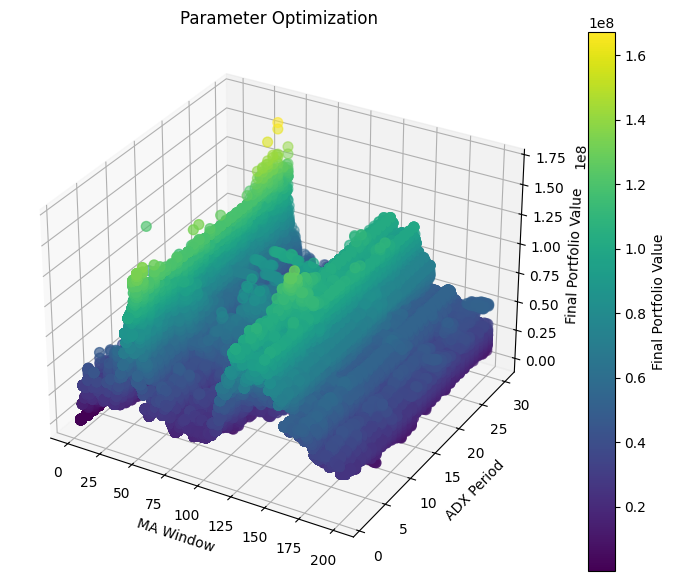

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate moving averages
def calculate_moving_averages(df, ma_window=50):
    """Calculate moving averages."""
    df['SMA'] = df['Close'].rolling(window=ma_window).mean()
    return df

# Calculate ADX
def calculate_adx(df, period=14):
    """Calculate the Average Directional Index (ADX)."""
    high = df['High']
    low = df['Low']
    close = df['Close']

    df['TR'] = np.maximum.reduce([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ])

    df['+DM'] = np.where((high - high.shift(1)) > (low.shift(1) - low),
                         np.maximum(high - high.shift(1), 0), 0)
    df['-DM'] = np.where((low.shift(1) - low) > (high - high.shift(1)),
                         np.maximum(low.shift(1) - low, 0), 0)

    df['TR14'] = df['TR'].rolling(window=period).sum()
    df['+DM14'] = df['+DM'].rolling(window=period).sum()
    df['-DM14'] = df['-DM'].rolling(window=period).sum()

    df['+DI14'] = (df['+DM14'] / df['TR14']) * 100
    df['-DI14'] = (df['-DM14'] / df['TR14']) * 100
    df['DX'] = (abs(df['+DI14'] - df['-DI14']) / (df['+DI14'] + df['-DI14'])) * 100

    df['ADX'] = df['DX'].rolling(window=period).mean()
    return df

# Define the stock symbol and time period
symbol = 'BTC-USD'
start_date = '2014-01-01'
end_date = '2024-12-27'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Initialize parameter ranges
ma_windows = range(1, 201)
periods = range(1, 31)
adx_thresholds = range(1, 51)

# Store results
results = []

for ma_window in ma_windows:
    for period in periods:
        for adx_threshold in adx_thresholds:
            # Calculate indicators
            df = calculate_moving_averages(df, ma_window=ma_window)
            df = calculate_adx(df, period=period)

            # Define entry and exit signals
            df['Entry'] = (
                (df['ADX'] > adx_threshold) &  # ADX above threshold
                (df['Close'] > df['SMA'])      # Price above SMA
            )

            df['Exit'] = (
                (df['ADX'] > adx_threshold) &  # ADX above threshold
                (df['Close'] < df['SMA'])      # Price below SMA
            )

            # Convert signals to boolean arrays
            entries = df['Entry'].to_numpy()
            exits = df['Exit'].to_numpy()

            # Backtest using vectorbt
            portfolio = vbt.Portfolio.from_signals(
                close=df['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            # Store performance metrics
            results.append({
                'ma_window': ma_window,
                'period': period,
                'adx_threshold': adx_threshold,
                'final_value': portfolio.value()[-1]
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best parameters
best_result = results_df.loc[results_df['final_value'].idxmax()]
print("Best Parameters:")
print(best_result)

# Prepare data for 3D plotting
X, Y, Z = (
    results_df['ma_window'],
    results_df['period'],
    results_df['final_value']
)

# Plot results in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X, Y, Z, c=Z, cmap='viridis', s=50)
ax.set_xlabel('MA Window')
ax.set_ylabel('ADX Period')
ax.set_zlabel('Final Portfolio Value')
plt.colorbar(sc, label='Final Portfolio Value')
plt.title('Parameter Optimization')
plt.show()
